
Summary (rounded):
   epsilon  retain_energy  mean_f_unit  std_f_unit  mean_f_domain  \
0     0.01           0.99        0.410       0.061           8.19   
1     0.05           0.95        0.321       0.056           6.41   
2     0.10           0.90        0.270       0.057           5.40   

   std_f_domain  theory_f_unit  theory_f_domain  nyquist_samples_empirical  \
0         1.212          0.409            8.188                      16.38   
1         1.120          0.312            6.236                      12.82   
2         1.146          0.262            5.235                      10.80   

   nyquist_samples_theory  
0                  16.377  
1                  12.472  
2                  10.470  


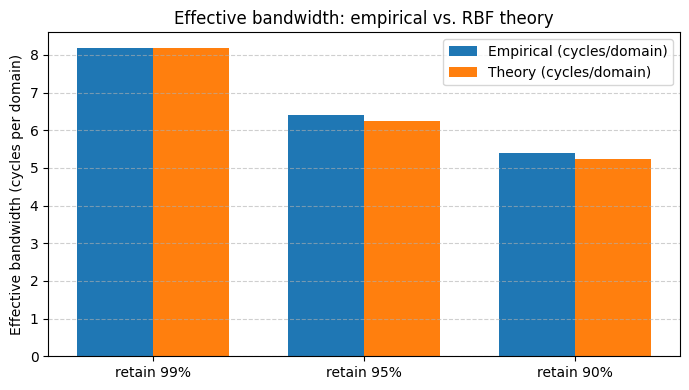

In [1]:
"""
FFT-based effective bandwidth for an RBF GP 
------------
- Simulates n_trials dense GP draws with RBF kernel (ell_true, var_true)
- For each draw, computes the FFT power spectrum on a fine grid
  (with mean removal and Hann window), then finds the frequency
  where the cumulative energy reaches (1 - eps) for eps in {0.01, 0.05, 0.10}
- Reports effective bandwidth in cycles per unit length and per domain
- Compares empirical means to RBF theory:
    f_eps = (1/(sqrt(2)*pi)) * erfinv(1 - eps) * (1/ell_true) 

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# -----------------------------
# Parameters (edit as needed)
# -----------------------------
left, right = -5, 15      # domain bounds
L = right - left          # domain length
n_fine = 500              # dense grid size for "ground truth"
var_true = 2.0            # process variance (sigma^2)
ell_true = 1.0            # RBF length-scale (ell_0)
noise = 1e-6              # tiny jitter for numerical stability
n_trials = 100            # number of realizations
eps_list = [0.01, 0.05, 0.10]  # tail levels (retain = 1 - eps)

rng = np.random.default_rng(42)

# -----------------------------
# Helpers
# -----------------------------
def rbf_kernel(x, ell, var):
    """Squared-exponential kernel matrix for 1D input x (n x 1)."""
    d2 = (x - x.T)**2
    return var * np.exp(-0.5 * d2 / (ell**2))

def effective_bandwidth_fft(y, L, eps):
    """
    Return effective bandwidth where cumulative spectral energy reaches (1 - eps).
    Outputs: (cycles per unit length, cycles per domain).
    """
    n = len(y)
    # Remove mean and apply Hann window to reduce leakage
    y = y - np.mean(y)
    w = np.hanning(n)
    y_w = y * w

    # One-sided FFT for real signal
    dx_unit = L / n                          # spacing of fine grid in domain units
    Y = rfft(y_w)
    freqs_unit = rfftfreq(n, d=dx_unit)      # cycles per unit length (one-sided)

    # Power spectrum (normalized to unit energy)
    S = np.abs(Y)**2
    S_sum = S.sum()
    if S_sum == 0.0:
        return 0.0, 0.0
    S /= S_sum
    cum = np.cumsum(S)

    # Index where cumulative energy first reaches (1 - eps)
    idx = np.searchsorted(cum, 1.0 - eps, side='left')
    if idx >= len(freqs_unit):
        idx = len(freqs_unit) - 1

    f_unit = float(freqs_unit[idx])
    f_domain = f_unit * L
    return f_unit, f_domain

def erfinv_approx(x):
    """
    Approximation to inverse error function (Winitzki / Mike Giles-style).
    If you have SciPy, replace with: from scipy.special import erfinv
    """
    x = np.clip(x, -0.999999, 0.999999)
    a = 0.147
    ln = np.log(1.0 - x*x)
    term = (2.0/(np.pi*a) + ln/2.0)
    return np.sign(x) * np.sqrt( np.sqrt(term*term - ln/a) - term )

def theoretical_f_unit(eps, ell):
    """RBF theory: f_eps = (1/(sqrt(2)*pi))*erfinv(1-eps) * 1/ell (cycles per unit length)."""
    inv = erfinv_approx(1.0 - eps)
    c = inv / (np.sqrt(2.0) * np.pi)
    return c / ell
 
X = np.linspace(left, right, n_fine)[:, None]
K = rbf_kernel(X, ell_true, var_true) + noise*np.eye(n_fine)
K = K + 1e-10*np.eye(n_fine)  # extra jitter for Cholesky stability
L_chol = np.linalg.cholesky(K)
 
records = []
for t in range(n_trials):
    # Efficient draw: y = L_chol @ z, z ~ N(0, I)
    z = rng.standard_normal(n_fine)
    y = L_chol @ z

    row = {"trial": t}
    for eps in eps_list:
        f_unit, f_domain = effective_bandwidth_fft(y, L, eps)
        row[f"f_unit@retain={1-eps:.2f}"] = f_unit
        row[f"f_domain@retain={1-eps:.2f}"] = f_domain
    records.append(row)

df = pd.DataFrame(records)
 
summary_rows = []
for eps in eps_list:
    key_u = f"f_unit@retain={1-eps:.2f}"
    key_d = f"f_domain@retain={1-eps:.2f}"
    mean_u, std_u = df[key_u].mean(), df[key_u].std()
    mean_d, std_d = df[key_d].mean(), df[key_d].std()
    f_unit_th = theoretical_f_unit(eps, ell_true)
    summary_rows.append({
        "epsilon": eps,
        "retain_energy": 1-eps,
        "mean_f_unit": mean_u,
        "std_f_unit": std_u,
        "mean_f_domain": mean_d,
        "std_f_domain": std_d,
        "theory_f_unit": f_unit_th,
        "theory_f_domain": f_unit_th * L,
        # Nyquist samples per domain to cover effective bandwidth (empirical/theory)
        "nyquist_samples_empirical": 2.0 * mean_d,
        "nyquist_samples_theory": 2.0 * f_unit_th * L,
    })

summary = pd.DataFrame(summary_rows)
 
df.to_csv("fft_bandwidth_trials.csv", index=False)
summary.to_csv("fft_bandwidth_summary.csv", index=False)

print("\nSummary (rounded):")
print(summary.round(3))

 
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(eps_list))
ax.bar(x - 0.18, summary["mean_f_domain"], 0.36, label="Empirical (cycles/domain)")
ax.bar(x + 0.18, summary["theory_f_domain"], 0.36, label="Theory (cycles/domain)")
ax.set_xticks(x)
ax.set_xticklabels([f"retain {int((1-e)*100)}%" for e in eps_list])
ax.set_ylabel("Effective bandwidth (cycles per domain)")
ax.set_title("Effective bandwidth: empirical vs. RBF theory")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
